In [119]:
import pandas as pd
import pandas_profiling

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import pickle

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import lightgbm as lgb
import xgboost as xgb


pd.options.display.max_columns = 100
random_state = 123

## データ修正

In [120]:
#データ読み込み
train = pd.read_csv("data/train_df.csv")
test = pd.read_csv("data/test_df.csv")
sample= pd.read_csv("data/submission.csv",header = None)

In [121]:
train.head()

,id,personal_id_1,personal_id_2,facility_id,age,bmi,situation_1,situation_2,ethnicity,gender,height,weight,icu_id,icu_1,icu_2,icu_3,icu_4,icu_5,icu_6,icu_7,icu_8,glasgow_coma_scale_1,glasgow_coma_scale_2,glasgow_coma_scale_3,glasgow_coma_scale_4,heart_rate,blood_oxy,arterial_pressure,respiratory_rate,temp,blood_pressure_1,blood_pressure_2,blood_pressure_3,blood_pressure_4,v1_heartrate_max,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,w17,w18,x1,x2,x3,x4,x5,x6,aids,cirrhosis,diabetes,hepatic_issue,immunosuppression,leukemia,lymphoma,carcinoma,body_system_1,body_system_2,target_label
0,0,114501,58009,51,69.0,24.731460,0,1.0,Caucasian,M,175.30,76.0,698,Floor,admit,MICU,25.801389,302.0,109.09,0,0.0,3.0,6.0,0.0,3.0,100.0,0.0,50.0,33.0,NaN,59.0,46.0,59.0,46.0,96.0,91.0,84.0,53.0,84.0,53.0,16.0,14.0,100.0,97.0,124.0,67.0,124.0,67.0,37.10,36.80,46.0,46.0,46.0,46.0,96.0,96.0,53.0,53.0,53.0,53.0,16.0,16.0,100.0,100.0,75.0,67.0,75.0,67.0,243.0,76.0,3.5,3.5,0.25,0.07,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,0
1,1,44353,112590,19,64.0,28.666129,0,1.0,Caucasian,M,183.00,96.0,657,Floor,admit,CCU-CTICU,3.639583,NaN,0.19,0,0.0,1.0,1.0,0.0,1.0,117.0,0.0,145.0,4.0,36.72,73.0,48.0,73.0,48.0,111.0,62.0,100.0,59.0,100.0,59.0,30.0,0.0,97.0,87.0,178.0,99.0,178.0,99.0,37.38,36.72,NaN,NaN,NaN,NaN,83.0,80.0,NaN,NaN,NaN,NaN,17.0,8.0,94.0,93.0,NaN,NaN,NaN,NaN,158.0,109.0,4.2,4.2,0.42,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0
2,2,8023,1677,16,74.0,18.144869,0,0.0,Caucasian,F,166.00,50.0,482,Accident & Emergency,admit,MICU,0.059028,304.0,307.01,0,0.0,4.0,6.0,0.0,5.0,53.0,0.0,50.0,6.0,36.10,65.0,39.0,65.0,39.0,71.0,55.0,73.0,50.0,73.0,50.0,18.0,11.0,100.0,100.0,122.0,69.0,122.0,69.0,37.00,36.10,65.0,65.0,65.0,65.0,62.0,59.0,73.0,73.0,73.0,73.0,18.0,13.0,100.0,100.0,100.0,100.0,100.0,100.0,73.0,62.0,4.2,4.1,0.07,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal,0
3,3,106340,74166,188,60.0,23.047667,0,0.0,Caucasian,M,182.90,77.1,855,Accident & Emergency,admit,CCU-CTICU,0.014583,123.0,702.01,0,0.0,4.0,6.0,0.0,5.0,102.0,0.0,127.0,4.0,37.00,87.0,69.0,87.0,69.0,99.0,75.0,114.0,86.0,114.0,86.0,21.0,15.0,100.0,96.0,153.0,123.0,153.0,123.0,37.10,36.60,80.0,73.0,80.0,73.0,99.0,96.0,97.0,86.0,97.0,86.0,18.0,17.0,98.0,97.0,124.0,123.0,124.0,123.0,373.0,46.0,4.2,3.2,0.01,0.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,0
4,4,118467,52717,168,75.0,20.190265,0,0.0,Caucasian,F,160.02,51.7,136,Accident & Emergency,admit,Med-Surg ICU,0.004861,304.0,308.01,0,0.0,4.0,6.0,0.0,5.0,90.0,0.0,68.0,28.0,36.80,87.0,87.0,87.0,87.0,90.0,90.0,105.0,105.0,105.0,105.0,14.0,11.0,97.0,92.0,147.0,147.0,147.0,147.0,36.80,36.80,100.0,56.0,100.0,56.0,67.0,61.0,104.0,68.0,104.0,68.0,28.0,24.0,94.0,90.0,142.0,114.0,142.0,114.0,NaN,NaN,NaN,NaN,0.08,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Gastrointestinal,Gastrointestinal,0


In [122]:
test.head()

,id,personal_id_1,personal_id_2,facility_id,age,bmi,situation_1,situation_2,ethnicity,gender,height,weight,icu_id,icu_1,icu_2,icu_3,icu_4,icu_5,icu_6,icu_7,icu_8,glasgow_coma_scale_1,glasgow_coma_scale_2,glasgow_coma_scale_3,glasgow_coma_scale_4,heart_rate,blood_oxy,arterial_pressure,respiratory_rate,temp,blood_pressure_1,blood_pressure_2,blood_pressure_3,blood_pressure_4,v1_heartrate_max,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,w17,w18,x1,x2,x3,x4,x5,x6,aids,cirrhosis,diabetes,hepatic_issue,immunosuppression,leukemia,lymphoma,carcinoma,body_system_1,body_system_2
0,51359,12058,66446,83,37.0,NaN,0,0.0,Caucasian,M,182.9,NaN,95,Floor,readmit,Med-Surg ICU,0.902778,113.0,501.02,0,0.0,4.0,6.0,0.0,5.0,123.0,0.0,76.0,4.0,37.0,74.0,56.0,74.0,56.0,120.0,103.0,93.0,74.0,93.0,74.0,19.0,6.0,99.0,90.0,127.0,106.0,127.0,106.0,37.3,36.9,65.0,60.0,65.0,60.0,112.0,104.0,84.0,84.0,84.0,84.0,19.0,16.0,99.0,92.0,115.0,111.0,115.0,111.0,160.0,122.0,3.5,3.5,-1.00,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,51360,92348,32311,185,60.0,32.961764,1,0.0,Caucasian,M,185.4,113.3,679,Operating Room / Recovery,admit,Neuro ICU,0.406944,NaN,0.25,0,0.0,3.0,6.0,0.0,4.0,60.0,0.0,151.0,5.0,37.2,85.0,81.0,85.0,81.0,83.0,68.0,132.0,107.0,132.0,107.0,14.0,11.0,97.0,92.0,191.0,146.0,191.0,146.0,37.4,37.2,85.0,85.0,85.0,85.0,68.0,68.0,132.0,132.0,132.0,132.0,11.0,11.0,97.0,97.0,191.0,191.0,191.0,191.0,259.0,184.0,4.4,4.4,0.05,0.01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,51361,68371,20639,157,70.0,19.295957,0,1.0,Caucasian,M,177.8,61.0,697,Floor,admit,SICU,0.977083,303.0,211.09,0,0.0,3.0,5.0,0.0,1.0,106.0,0.0,58.0,39.0,36.5,78.0,51.0,78.0,51.0,87.0,69.0,98.0,73.0,98.0,73.0,20.0,14.0,100.0,100.0,127.0,103.0,127.0,103.0,36.6,36.5,78.0,78.0,78.0,78.0,87.0,87.0,98.0,98.0,98.0,98.0,14.0,14.0,100.0,100.0,127.0,127.0,127.0,127.0,113.0,93.0,4.1,4.1,0.13,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
3,51362,19544,116026,60,54.0,27.900747,0,1.0,Caucasian,M,180.3,90.7,538,Accident & Emergency,admit,Med-Surg ICU,0.172917,122.0,703.03,0,0.0,4.0,6.0,0.0,4.0,118.0,0.0,189.0,53.0,NaN,144.0,73.0,144.0,73.0,118.0,59.0,184.0,81.0,181.0,81.0,53.0,0.0,100.0,94.0,232.0,101.0,232.0,101.0,35.1,34.5,112.0,95.0,112.0,95.0,102.0,88.0,136.0,116.0,136.0,116.0,29.0,15.0,98.0,97.0,183.0,156.0,183.0,156.0,101.0,101.0,3.7,3.7,0.03,0.02,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
4,51363,85588,102404,196,85.0,39.414062,0,1.0,Caucasian,F,160.0,100.9,809,Accident & Emergency,admit,CSICU,0.031944,117.0,106.01,0,0.0,4.0,6.0,0.0,5.0,165.0,0.0,63.0,37.0,36.7,84.0,52.0,84.0,52.0,163.0,114.0,91.0,63.0,91.0,63.0,32.0,18.0,98.0,89.0,119.0,90.0,119.0,90.0,37.1,36.7,66.0,66.0,66.0,66.0,160.0,144.0,77.0,77.0,77.0,77.0,27.0,27.0,96.0,96.0,119.0,119.0,119.0,119.0,110.0,110.0,3.9,3.9,0.15,0.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular


In [123]:
#カテゴリと考えられる変数を変更
ids = ['id', 'personal_id_1', 'personal_id_2',]
# cats = ['facility_id', 'icu_5', 'icu_7', 'icu_8', 'icu_id', 'situation_1', 'situation_2', 'glasgow_coma_scale_3']
cats = ['facility_id', 'icu_5', 'icu_7', 'icu_8', 'icu_id', 'situation_1', 'situation_2', 'glasgow_coma_scale_3', 'blood_oxy']
#cats = ['facility_id', 'icu_5', 'icu_id'] #best_cats
dis_name = ['aids', 'cirrhosis', 'diabetes', 'hepatic_issue', 'immunosuppression', 'leukemia', 'lymphoma', 'carcinoma'] 
for c in ids:
    train[c] = train[c].astype(object)
    test[c] = test[c].astype(object)

for c in cats:
    train[c] = train[c].astype(object)
    test[c] = test[c].astype(object)
    
for c in dis_name:
    train[c] = train[c].astype(object)
    test[c] = test[c].astype(object)

In [124]:
# 数値データ
y_train=train[['target_label']]
x_train=train.drop('target_label',axis=1)
col_num = x_train.columns[x_train.dtypes!='object'].values.tolist()
print('数値データ')
print(col_num)
print('-'*100)
col_cat = x_train.columns[x_train.dtypes=='object'].values.tolist()
print('カテゴリ変数')
print(col_cat)

数値データ
['age', 'bmi', 'height', 'weight', 'icu_4', 'icu_6', 'glasgow_coma_scale_1', 'glasgow_coma_scale_2', 'glasgow_coma_scale_4', 'heart_rate', 'arterial_pressure', 'respiratory_rate', 'temp', 'blood_pressure_1', 'blood_pressure_2', 'blood_pressure_3', 'blood_pressure_4', 'v1_heartrate_max', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 'w11', 'w12', 'w13', 'w14', 'w15', 'w16', 'w17', 'w18', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']
----------------------------------------------------------------------------------------------------
カテゴリ変数
['id', 'personal_id_1', 'personal_id_2', 'facility_id', 'situation_1', 'situation_2', 'ethnicity', 'gender', 'icu_id', 'icu_1', 'icu_2', 'icu_3', 'icu_5', 'icu_7', 'icu_8', 'glasgow_coma_scale_3', 'blood_oxy', 'aids', 'cirrhosis', 'diabetes', 'hepatic_issue', 'immunosuppression', 'leukemia', 'lymphoma', 'carcinoma', 'body_system_1', 'body_system_

In [125]:
"""
エンコーディングの方針
nunique が比較的少ない変数はOne Hot Encoding
nunique が多い変数はLabel encoeding してから　embeding

body_systemは同一病種があり合算してOne Hot Encording
"""

low_cat_cols = [] # nunique が比較的少ない変数
high_cat_cols = [] # nunique が多い変数

for c in col_cat:
    nunq = x_train[c].nunique()
    if nunq>30:
        high_cat_cols.append(c)
    else:
        low_cat_cols.append(c)
        
body = ['body_system_1', 'body_system_2']
for r in body:
    low_cat_cols.remove(r)
        
print('-'*20, 'unique_low', '-'*20)
print(low_cat_cols)
print('-'*20, 'unique_high', '-'*20)
print(high_cat_cols)

print('-'*20, 'body_systems', '-'*20)
print(body)

-------------------- unique_low --------------------
['situation_1', 'situation_2', 'ethnicity', 'gender', 'icu_1', 'icu_2', 'icu_3', 'icu_7', 'icu_8', 'glasgow_coma_scale_3', 'blood_oxy', 'aids', 'cirrhosis', 'diabetes', 'hepatic_issue', 'immunosuppression', 'leukemia', 'lymphoma', 'carcinoma']
-------------------- unique_high --------------------
['id', 'personal_id_1', 'personal_id_2', 'facility_id', 'icu_id', 'icu_5']
-------------------- body_systems --------------------
['body_system_1', 'body_system_2']


In [126]:
#少ない要素は確認してみる
for c in low_cat_cols:
    print(f"{c}:\t{x_train[c].unique()}")

situation_1:	[0 1]
situation_2:	[1.0 0.0 nan]
ethnicity:	['Caucasian' 'African American' 'Other/Unknown' 'Hispanic' nan 'Asian'
 'Native American']
gender:	['M' 'F' nan]
icu_1:	['Floor' 'Accident & Emergency' 'Operating Room / Recovery'
 'Other Hospital' 'Other ICU' nan]
icu_2:	['admit' 'readmit' 'transfer']
icu_3:	['MICU' 'CCU-CTICU' 'Med-Surg ICU' 'Neuro ICU' 'CSICU' 'SICU' 'CTICU'
 'Cardiac ICU']
icu_7:	[0 1]
icu_8:	[0.0 1.0 nan]
glasgow_coma_scale_3:	[0.0 1.0 nan]
blood_oxy:	[0.0 1.0 nan]
aids:	[0.0 nan 1.0]
cirrhosis:	[0.0 1.0 nan]
diabetes:	[1.0 0.0 nan]
hepatic_issue:	[0.0 1.0 nan]
immunosuppression:	[0.0 1.0 nan]
leukemia:	[0.0 1.0 nan]
lymphoma:	[0.0 nan 1.0]
carcinoma:	[0.0 1.0 nan]


In [127]:
#nunique が少ない変数はOne Hot

dict_low_cat = {}
for col in low_cat_cols:
    print(col)
    value_fillna = 'unknown'
    x_train[col] = x_train[col].fillna(value_fillna)
    x_train[col] = x_train[col].astype(str)
    
    dict_low_cat[col] = {}
    dict_low_cat[col]['fillna'] = value_fillna
    
x_train = pd.get_dummies(x_train, dummy_na=False, drop_first=False, columns=low_cat_cols)
print('Done')

situation_1
situation_2
ethnicity
gender
icu_1
icu_2
icu_3
icu_7
icu_8
glasgow_coma_scale_3
blood_oxy
aids
cirrhosis
diabetes
hepatic_issue
immunosuppression
leukemia
lymphoma
carcinoma
Done


In [129]:
# nunique が多い変数はlabel encoding

ids = ['id', 'personal_id_1', 'personal_id_2']
for i in ids:
    high_cat_cols.remove(i)
    
dict_high_cat = {}
for col in high_cat_cols:
    print(col)
    value_fillna = 'unknown'
    x_train[col] = x_train[col].fillna(value_fillna)
    x_train[col] = x_train[col].astype(str)
    # strに変換
    le = LabelEncoder()
    le.fit(x_train[col])
    list_label = sorted(list(set(le.classes_) | set(['unknown'])))
    # print(list_label)
    map_label = {j:i for i,j in enumerate(list_label)}
    x_train[col] = x_train[col].map(map_label)
    
    dict_high_cat[col] = {}
    dict_high_cat[col]['fillna'] = value_fillna
    dict_high_cat[col]['map_label'] = map_label
    dict_high_cat[col]['num_label'] = len(list_label)

print('Done')

facility_id
icu_id
icu_5
Done


In [130]:
# 数値データは標準化
dict_num = {}
for col in col_num:
    print(col)
    # 欠損値を0へ
    value_fillna = 0 
    x_train[col] = x_train[col].fillna(value_fillna)
    # 正規化
    value_min = x_train[col].min()
    value_max = x_train[col].max()
    value_mean = x_train[col].mean()
    value_std = x_train[col].std()
    #train[col] = (train[col] - value_min) / (value_max - value_min)
    x_train[col] = (x_train[col] - value_mean) / value_std
    
    dict_num[col] = {}
    dict_num[col]['fillna'] = value_fillna
    dict_num[col]['min'] = value_min
    dict_num[col]['max'] = value_max
    dict_num[col]['mean'] = value_mean    
    dict_num[col]['std'] = value_std    
    
print('Done')

age
bmi
height
weight
icu_4
icu_6
glasgow_coma_scale_1
glasgow_coma_scale_2
glasgow_coma_scale_4
heart_rate
arterial_pressure
respiratory_rate
temp
blood_pressure_1
blood_pressure_2
blood_pressure_3
blood_pressure_4
v1_heartrate_max
v2
v3
v4
v5
v6
v7
v8
v9
v10
v11
v12
v13
v14
v15
v16
w1
w2
w3
w4
w5
w6
w7
w8
w9
w10
w11
w12
w13
w14
w15
w16
w17
w18
x1
x2
x3
x4
x5
x6
Done


In [132]:
def transform_data(input_x):
    output_x = input_x.copy()
    
    for col in col_num:
        value_fillna = dict_num[col]['fillna']
        output_x[col] = output_x[col].fillna(value_fillna)
        
        value_min = dict_num[col]['min']
        value_max = dict_num[col]['max']
        value_mean = dict_num[col]['mean']
        value_std = dict_num[col]['std']
        
        # output_x[col]  = (output_x[col] - value_min ) / (value_max - value_min)
        output_x[col]  = (output_x[col] - value_mean ) / (value_std)
        
        
    for col in low_cat_cols:
        value_fillna = dict_low_cat[col]['fillna']
        output_x[col] = output_x[col].fillna(value_fillna)
        
        output_x[col] = output_x[col].astype(str)
        
    for col in high_cat_cols:
        value_fillna = dict_high_cat[col]['fillna']
        output_x[col] = output_x[col].fillna(value_fillna)
        
        output_x[col] = output_x[col].astype(str)
        
        map_label = dict_high_cat[col]['map_label']#辞書からlabel_encordの辞書を取り出す
        output_x[col] = output_x[col].map(map_label)
        
        #対応するものがない場合はunkoumn
        output_x[col] = output_x[col].fillna(map_label['unknown'])
        
    output_x = pd.get_dummies(output_x, dummy_na=False, drop_first=False, columns=low_cat_cols)
        
    return output_x

x_test = transform_data(test)

In [135]:
print(x_test.shape, x_train.shape)

(12840, 145) (51359, 145)


In [134]:
#OneHotencorder(doby)
data = [x_train, x_test]
#被っているものはbody_system_2をNanに
for d in data:   
    d['body_system_2'] = d['body_system_2'].where(d['body_system_1'] != d['body_system_2'])
#Nanはunknoun
    d.fillna('unknown', inplace=True)
    d['body_system_2'] = d['body_system_2'].replace('Undefined diagnoses', 'Undefined Diagnoses')
print(x_train.shape, x_test.shape)

body_train = pd.get_dummies(x_train[body].stack(), dummy_na=False, prefix='ohe').groupby(level=0).sum()
body_test = pd.get_dummies(x_test[body].stack(), dummy_na=False, prefix='ohe').groupby(level=0).sum()
print(body1.columns, body1.shape)
print(body2.columns, body2.shape)

x_train = pd.concat([x_train.drop(body, axis=1), body_train], axis=1).drop('ohe_unknown', axis=1)
x_test = pd.concat([x_test.drop(body, axis=1), body_test], axis=1).drop('ohe_unknown', axis=1)

(51359, 132) (12840, 132)
Index(['ohe_Cardiovascular', 'ohe_Gastrointestinal', 'ohe_Genitourinary',
       'ohe_Gynecological', 'ohe_Haematologic', 'ohe_Hematological',
       'ohe_Metabolic', 'ohe_Musculoskeletal/Skin', 'ohe_Neurologic',
       'ohe_Neurological', 'ohe_Renal/Genitourinary', 'ohe_Respiratory',
       'ohe_Sepsis', 'ohe_Trauma', 'ohe_Undefined Diagnoses', 'ohe_unknown'],
      dtype='object') (51359, 16)
Index(['ohe_Cardiovascular', 'ohe_Gastrointestinal', 'ohe_Genitourinary',
       'ohe_Gynecological', 'ohe_Haematologic', 'ohe_Hematological',
       'ohe_Metabolic', 'ohe_Musculoskeletal/Skin', 'ohe_Neurologic',
       'ohe_Neurological', 'ohe_Renal/Genitourinary', 'ohe_Respiratory',
       'ohe_Sepsis', 'ohe_Trauma', 'ohe_Undefined Diagnoses', 'ohe_unknown'],
      dtype='object') (12840, 16)


In [136]:
# idを別のdfに、
id_train = x_train[['id']]
x_train = x_train.drop(['id'], axis=1)

id_test = x_test[id_train.columns]
x_test = x_test.drop(['id'], axis=1)

print('学習用データ: {},   学習ラベル：{},  テストデータ：{}、学習IDデータ:{}, テストIDデータ:{}'.format(
    x_train.shape, y_train.shape, x_test.shape, id_train.shape, id_test.shape))
# print('taget_encord用学習データ：{},  target_encord用テストデータ：{}'.format(
#       te_base_train.shape, te_base_test.shape))

print('陽性ラベルの割合: {}'.format(
    y_train.value_counts()[1]  / len(train)))

学習用データ: (51359, 144),   学習ラベル：(51359, 1),  テストデータ：(12840, 144)、学習IDデータ:(51359, 1), テストIDデータ:(12840, 1)
陽性ラベルの割合: 0.08629451508012227


In [137]:
#初期データ
display(train)
display(test)

,id,personal_id_1,personal_id_2,facility_id,age,bmi,situation_1,situation_2,ethnicity,gender,height,weight,icu_id,icu_1,icu_2,icu_3,icu_4,icu_5,icu_6,icu_7,icu_8,glasgow_coma_scale_1,glasgow_coma_scale_2,glasgow_coma_scale_3,glasgow_coma_scale_4,heart_rate,blood_oxy,arterial_pressure,respiratory_rate,temp,blood_pressure_1,blood_pressure_2,blood_pressure_3,blood_pressure_4,v1_heartrate_max,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,w17,w18,x1,x2,x3,x4,x5,x6,aids,cirrhosis,diabetes,hepatic_issue,immunosuppression,leukemia,lymphoma,carcinoma,body_system_1,body_system_2,target_label
0,0,114501,58009,51,69.0,24.731460,0,1.0,Caucasian,M,175.30,76.0,698,Floor,admit,MICU,25.801389,302.0,109.09,0,0.0,3.0,6.0,0.0,3.0,100.0,0.0,50.0,33.0,NaN,59.0,46.0,59.0,46.0,96.0,91.0,84.0,53.0,84.0,53.0,16.0,14.0,100.0,97.0,124.0,67.0,124.0,67.0,37.10,36.80,46.0,46.0,46.0,46.0,96.0,96.0,53.0,53.0,53.0,53.0,16.0,16.0,100.0,100.0,75.0,67.0,75.0,67.0,243.0,76.0,3.5,3.5,0.25,0.07,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,0
1,1,44353,112590,19,64.0,28.666129,0,1.0,Caucasian,M,183.00,96.0,657,Floor,admit,CCU-CTICU,3.639583,NaN,0.19,0,0.0,1.0,1.0,0.0,1.0,117.0,0.0,145.0,4.0,36.72,73.0,48.0,73.0,48.0,111.0,62.0,100.0,59.0,100.0,59.0,30.0,0.0,97.0,87.0,178.0,99.0,178.0,99.0,37.38,36.72,NaN,NaN,NaN,NaN,83.0,80.0,NaN,NaN,NaN,NaN,17.0,8.0,94.0,93.0,NaN,NaN,NaN,NaN,158.0,109.0,4.2,4.2,0.42,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0
2,2,8023,1677,16,74.0,18.144869,0,0.0,Caucasian,F,166.00,50.0,482,Accident & Emergency,admit,MICU,0.059028,304.0,307.01,0,0.0,4.0,6.0,0.0,5.0,53.0,0.0,50.0,6.0,36.10,65.0,39.0,65.0,39.0,71.0,55.0,73.0,50.0,73.0,50.0,18.0,11.0,100.0,100.0,122.0,69.0,122.0,69.0,37.00,36.10,65.0,65.0,65.0,65.0,62.0,59.0,73.0,73.0,73.0,73.0,18.0,13.0,100.0,100.0,100.0,100.0,100.0,100.0,73.0,62.0,4.2,4.1,0.07,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal,0
3,3,106340,74166,188,60.0,23.047667,0,0.0,Caucasian,M,182.90,77.1,855,Accident & Emergency,admit,CCU-CTICU,0.014583,123.0,702.01,0,0.0,4.0,6.0,0.0,5.0,102.0,0.0,127.0,4.0,37.00,87.0,69.0,87.0,69.0,99.0,75.0,114.0,86.0,114.0,86.0,21.0,15.0,100.0,96.0,153.0,123.0,153.0,123.0,37.10,36.60,80.0,73.0,80.0,73.0,99.0,96.0,97.0,86.0,97.0,86.0,18.0,17.0,98.0,97.0,124.0,123.0,124.0,123.0,373.0,46.0,4.2,3.2,0.01,0.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,0
4,4,118467,52717,168,75.0,20.190265,0,0.0,Caucasian,F,160.02,51.7,136,Accident & Emergency,admit,Med-Surg ICU,0.004861,304.0,308.01,0,0.0,4.0,6.0,0.0,5.0,90.0,0.0,68.0,28.0,36.80,87.0,87.0,87.0,87.0,90.0,90.0,105.0,105.0,105.0,105.0,14.0,11.0,97.0,92.0,147.0,147.0,147.0,147.0,36.80,36.80,100.0,56.0,100.0,56.0,67.0,61.0,104.0,68.0,104.0,68.0,28.0,24.0,94.0,90.0,142.0,114.0,142.0,114.0,NaN,NaN,NaN,NaN,0.08,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Gastrointestinal,Gastrointestinal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51354,51354,88819,81966,64,67.0,20.622289,1,0.0,Caucasian,F,142.20,41.7,683,Operating Room / Recovery,admit,Med-Surg ICU,1.352778,304.0,1409.01,1,0.0,4.0,6.0,0.0,5.0,132.0,0.0,66.0,34.0,36.80,70.0,56.0,70.0,56.0,128.0,90.0,87.0,65.0,87.0,65.0,29.0,22.0,100.0,96.0,101.0,82.0,101.0,82.0,37.00,36.80,59.0,59.0,59.0,59.0,128.0,128.0,67.0,67.0,67.0,67.0,22.0,22.0,100.0,100.0,82.0,82.0,82.0,82.0,152.0,134.0,4.4,4.1,0.02,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal,0
51355,51355,45825,3470,161,63.0,35.054523,0,0.0,Caucasian,M,175.20,107.6,413,Accident & Emergency,admit,Med-Surg ICU,0.005556,113.0,501.02,0,0.0,4.0,6.0,0.0,4.0,165.0,0.0,48.0,34.0,36.60,81.0,41.0,81.0,41.0,162.0,78.0,91.0,54.0,91.0,54.0,34.0,10.0,100

,id,personal_id_1,personal_id_2,facility_id,age,bmi,situation_1,situation_2,ethnicity,gender,height,weight,icu_id,icu_1,icu_2,icu_3,icu_4,icu_5,icu_6,icu_7,icu_8,glasgow_coma_scale_1,glasgow_coma_scale_2,glasgow_coma_scale_3,glasgow_coma_scale_4,heart_rate,blood_oxy,arterial_pressure,respiratory_rate,temp,blood_pressure_1,blood_pressure_2,blood_pressure_3,blood_pressure_4,v1_heartrate_max,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,w17,w18,x1,x2,x3,x4,x5,x6,aids,cirrhosis,diabetes,hepatic_issue,immunosuppression,leukemia,lymphoma,carcinoma,body_system_1,body_system_2
0,51359,12058,66446,83,37.0,NaN,0,0.0,Caucasian,M,182.9,NaN,95,Floor,readmit,Med-Surg ICU,0.902778,113.0,501.02,0,0.0,4.0,6.0,0.0,5.0,123.0,0.0,76.0,4.0,37.00,74.0,56.0,74.0,56.0,120.0,103.0,93.0,74.0,93.0,74.0,19.0,6.0,99.0,90.0,127.0,106.0,127.0,106.0,37.30,36.90,65.0,60.0,65.0,60.0,112.0,104.0,84.0,84.0,84.0,84.0,19.0,16.0,99.0,92.0,115.0,111.0,115.0,111.0,160.0,122.0,3.5,3.5,-1.00,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,51360,92348,32311,185,60.0,32.961764,1,0.0,Caucasian,M,185.4,113.30,679,Operating Room / Recovery,admit,Neuro ICU,0.406944,NaN,0.25,0,0.0,3.0,6.0,0.0,4.0,60.0,0.0,151.0,5.0,37.20,85.0,81.0,85.0,81.0,83.0,68.0,132.0,107.0,132.0,107.0,14.0,11.0,97.0,92.0,191.0,146.0,191.0,146.0,37.40,37.20,85.0,85.0,85.0,85.0,68.0,68.0,132.0,132.0,132.0,132.0,11.0,11.0,97.0,97.0,191.0,191.0,191.0,191.0,259.0,184.0,4.4,4.4,0.05,0.01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,51361,68371,20639,157,70.0,19.295957,0,1.0,Caucasian,M,177.8,61.00,697,Floor,admit,SICU,0.977083,303.0,211.09,0,0.0,3.0,5.0,0.0,1.0,106.0,0.0,58.0,39.0,36.50,78.0,51.0,78.0,51.0,87.0,69.0,98.0,73.0,98.0,73.0,20.0,14.0,100.0,100.0,127.0,103.0,127.0,103.0,36.60,36.50,78.0,78.0,78.0,78.0,87.0,87.0,98.0,98.0,98.0,98.0,14.0,14.0,100.0,100.0,127.0,127.0,127.0,127.0,113.0,93.0,4.1,4.1,0.13,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
3,51362,19544,116026,60,54.0,27.900747,0,1.0,Caucasian,M,180.3,90.70,538,Accident & Emergency,admit,Med-Surg ICU,0.172917,122.0,703.03,0,0.0,4.0,6.0,0.0,4.0,118.0,0.0,189.0,53.0,NaN,144.0,73.0,144.0,73.0,118.0,59.0,184.0,81.0,181.0,81.0,53.0,0.0,100.0,94.0,232.0,101.0,232.0,101.0,35.10,34.50,112.0,95.0,112.0,95.0,102.0,88.0,136.0,116.0,136.0,116.0,29.0,15.0,98.0,97.0,183.0,156.0,183.0,156.0,101.0,101.0,3.7,3.7,0.03,0.02,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
4,51363,85588,102404,196,85.0,39.414062,0,1.0,Caucasian,F,160.0,100.90,809,Accident & Emergency,admit,CSICU,0.031944,117.0,106.01,0,0.0,4.0,6.0,0.0,5.0,165.0,0.0,63.0,37.0,36.70,84.0,52.0,84.0,52.0,163.0,114.0,91.0,63.0,91.0,63.0,32.0,18.0,98.0,89.0,119.0,90.0,119.0,90.0,37.10,36.70,66.0,66.0,66.0,66.0,160.0,144.0,77.0,77.0,77.0,77.0,27.0,27.0,96.0,96.0,119.0,119.0,119.0,119.0,110.0,110.0,3.9,3.9,0.15,0.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12835,64194,79880,56511,19,39.0,23.147277,0,0.0,Caucasian,F,163.0,61.50,657,Accident & Emergency,admit,CCU-CTICU,0.155556,304.0,301.01,0,0.0,4.0,6.0,0.0,5.0,113.0,0.0,62.0,8.0,36.33,98.0,52.0,98.0,52.0,111.0,84.0,106.0,62.0,106.0,62.0,21.0,10.0,97.0,88.0,159.0,85.0,159.0,85.0,37.38,36.33,63.0,54.0,63.0,54.0,103.0,100.0,75.0,68.0,75.0,68.0,17.0,15.0,94.0,90.0,120.0,109.0,120.0,109.0,117.0,89.0,6.4,5.5,0.03,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal
12836,64195,97405,32055,136,79.0,27.759515,0,0.0,Caucasian,M,175.5,85.50,374,Accident & Emergency,admit,Med-Surg ICU,0.195139,112.0,107.01,0,0.0,4.0,6.0,0.0,5.0,103.0,0.0,46.0,13.0,36.30,77.0,43.0,77.0,43.0,99.0,69.0,82.0,51.0,82.0,51.0,19.

In [138]:
# 処理後
display(x_train)
display(x_test)

,personal_id_1,personal_id_2,facility_id,age,bmi,height,weight,icu_id,icu_4,icu_5,icu_6,glasgow_coma_scale_1,glasgow_coma_scale_2,glasgow_coma_scale_4,heart_rate,arterial_pressure,respiratory_rate,temp,blood_pressure_1,blood_pressure_2,blood_pressure_3,blood_pressure_4,v1_heartrate_max,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,...,icu_7_0,icu_7_1,icu_8_0.0,icu_8_1.0,icu_8_unknown,glasgow_coma_scale_3_0.0,glasgow_coma_scale_3_1.0,glasgow_coma_scale_3_unknown,blood_oxy_0.0,blood_oxy_1.0,blood_oxy_unknown,aids_0.0,aids_1.0,aids_unknown,cirrhosis_0.0,cirrhosis_1.0,cirrhosis_unknown,diabetes_0.0,diabetes_1.0,diabetes_unknown,hepatic_issue_0.0,hepatic_issue_1.0,hepatic_issue_unknown,immunosuppression_0.0,immunosuppression_1.0,immunosuppression_unknown,leukemia_0.0,leukemia_1.0,leukemia_unknown,lymphoma_0.0,lymphoma_1.0,lymphoma_unknown,carcinoma_0.0,carcinoma_1.0,carcinoma_unknown,ohe_Cardiovascular,ohe_Gastrointestinal,ohe_Genitourinary,ohe_Gynecological,ohe_Haematologic,ohe_Hematological,ohe_Metabolic,ohe_Musculoskeletal/Skin,ohe_Neurologic,ohe_Neurological,ohe_Renal/Genitourinary,ohe_Respiratory,ohe_Sepsis,ohe_Trauma,ohe_Undefined Diagnoses
0,114501,58009,108,0.454939,-0.346609,0.357984,-0.195864,176,9.824534,37,-0.950656,-0.364472,0.431568,-0.551220,0.041533,-0.867503,0.491333,-4.578308,-1.455805,-0.299609,-1.309907,-0.254255,-0.303307,1.202584,-0.952377,-0.732021,-0.779641,-0.621162,-1.173673,0.229275,0.181114,0.601904,-0.910726,-1.414643,-0.750488,-1.256699,0.128090,0.251801,-1.135559,-0.712502,-0.871348,-0.521734,0.247360,0.604711,-1.198436,-0.877398,-0.875818,-0.624948,-0.632524,-0.060750,...,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,44353,112590,69,0.216694,0.055736,0.699250,0.508950,160,1.103269,44,-1.185370,-2.238334,-2.885738,-1.764683,0.568969,1.348143,-1.401226,0.256231,-0.760407,-0.151944,-0.668262,-0.115033,0.367228,-0.477670,-0.205836,-0.357263,-0.121707,-0.279873,0.112386,-2.497529,-0.302122,-0.277496,1.132586,0.106505,1.047114,0.135313,0.175810,0.237807,-3.113997,-2.992253,-2.560925,-2.491330,-0.239682,-0.044994,-3.066399,-2.953012,-2.448796,-2.386595,-0.518908,-1.204625,...,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,8023,1677,45,0.693185,-1.020130,-0.054194,-1.112121,97,-0.305776,39,-0.524075,0.572458,0.431568,0.662243,-1.416674,-0.867503,-1.270705,0.174602,-1.157777,-0.816439,-1.034917,-0.741531,-1.420866,-0.883248,-1.465624,-0.919400,-1.231970,-0.791807,-0.989951,-0.355040,0.181114,0.865724,-0.986404,-1.319571,-0.817066,-1.169699,0.111047,0.129353,-0.318379,0.229135,-0.173479,0.291794,-1.026441,-0.897732,-0.493545,-0.094147,-0.282242,0.039824,-0.405292,-0.489703,...,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,106340,74166,67,0.026097,-0.518788,0.694818,-0.157099,206,-0.323266,21,0.327276,0.572458,0.431568,0.662243,0.103584,0.928337,-1.401226,0.293095,-0.065009,1.398544,-0.026617,1.346798,-0.169200,0.275548,0.447387,1.329149,0.453985,1.255928,-0.714366,0.424046,0.181114,0.513964,0.186608,1.247367,0.214891,1.179323,0.128090,0.216816,0.326764,0.625613,0.377470,0.634333,0.359754,0.604711,0.352325,0.414965,0.430050,0.471927,-0.405292,0.082234,...,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,118467,52717,50,0.740834,-0.810975,-0.319229,-1.052212,14,-0.327092,39,-0.521920,0.572458,0.431568,0.662243,-0.268724,-0.447696,0.165030,0.266763,-0.065009,2.727534,-0.026617,2.599796,-0.571521,1.144644,0.027458,2.515883,0.083897,2.336676,-1.357396,-0.355040,-0.302122,0.162204,-0.040427,2.388228,0.015157,2.223332,0.076961,0.251801,1.186954,-0.216904,1.112068,-0.093561,-0.839117,-0.816519,0.599037,-0.289960,0.637801,-0.126369,0.730870,1.083125,...,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...

,personal_id_1,personal_id_2,facility_id,age,bmi,height,weight,icu_id,icu_4,icu_5,icu_6,glasgow_coma_scale_1,glasgow_coma_scale_2,glasgow_coma_scale_4,heart_rate,arterial_pressure,respiratory_rate,temp,blood_pressure_1,blood_pressure_2,blood_pressure_3,blood_pressure_4,v1_heartrate_max,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,...,icu_7_0,icu_7_1,icu_8_0.0,icu_8_1.0,icu_8_unknown,glasgow_coma_scale_3_0.0,glasgow_coma_scale_3_1.0,glasgow_coma_scale_3_unknown,blood_oxy_0.0,blood_oxy_1.0,blood_oxy_unknown,aids_0.0,aids_1.0,aids_unknown,cirrhosis_0.0,cirrhosis_1.0,cirrhosis_unknown,diabetes_0.0,diabetes_1.0,diabetes_unknown,hepatic_issue_0.0,hepatic_issue_1.0,hepatic_issue_unknown,immunosuppression_0.0,immunosuppression_1.0,immunosuppression_unknown,leukemia_0.0,leukemia_1.0,leukemia_unknown,lymphoma_0.0,lymphoma_1.0,lymphoma_unknown,carcinoma_0.0,carcinoma_1.0,carcinoma_unknown,ohe_Cardiovascular,ohe_Gastrointestinal,ohe_Genitourinary,ohe_Gynecological,ohe_Haematologic,ohe_Hematological,ohe_Metabolic,ohe_Musculoskeletal/Skin,ohe_Neurologic,ohe_Neurological,ohe_Renal/Genitourinary,ohe_Respiratory,ohe_Sepsis,ohe_Trauma,ohe_Undefined Diagnoses
0,12058,66446,132,-1.069832,-2.875558,0.694818,-2.874154,236.0,0.026262,11,-0.105922,0.572458,0.431568,0.662243,0.755123,-0.261115,-1.401226,0.293095,-0.710736,0.438718,-0.622430,0.441855,0.769549,1.897861,-0.532448,0.579633,-0.409553,0.573349,-0.898089,-1.328899,0.020035,-0.013676,-0.797209,0.439256,-0.650621,0.439816,0.162176,0.269294,-0.318379,-0.018664,-0.173479,0.077708,0.846795,0.929564,-0.105855,0.336640,0.044225,0.405449,-0.291676,-0.060750,...,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,92348,32311,64,0.026097,0.494992,0.805619,1.118613,167.0,-0.168861,44,-1.185241,-0.364472,0.431568,0.055512,-1.199494,1.488079,-1.335965,0.319427,-0.164352,2.284537,-0.118281,2.182130,-0.884438,-0.130031,1.287246,2.640803,1.194161,2.450439,-1.357396,-0.355040,-0.302122,0.162204,1.624494,2.340692,1.479870,2.179832,0.179219,0.321772,0.541811,1.220331,0.561119,1.148140,-0.801653,-0.532273,1.585885,2.216441,1.468808,2.000903,-1.200605,-0.775672,...,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,68371,20639,42,0.502588,-0.902424,0.468785,-0.724474,175.0,0.055504,38,-0.730814,-0.364472,-0.231893,-1.764683,0.227687,-0.680922,0.882897,0.227266,-0.512051,0.069555,-0.439103,0.093800,-0.705628,-0.072091,-0.299154,0.517173,-0.203949,0.516468,-0.806228,0.229275,0.181114,0.865724,-0.797209,0.296649,-0.650621,0.309315,0.042875,0.199324,0.240745,0.873412,0.304010,0.848419,-0.089823,0.239252,0.387570,0.884916,0.459728,0.870790,-0.859757,-0.346719,...,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,19544,116026,114,-0.259798,-0.022529,0.579586,0.322174,122.0,-0.260957,20,0.329474,0.572458,0.431568,0.055512,0.599995,2.374337,1.796546,-4.578308,2.766253,1.693875,2.585796,1.625242,0.680144,-0.651489,3.713504,1.016850,3.209083,0.971520,2.225197,-2.497529,0.181114,0.338084,3.175898,0.201577,2.844715,0.222314,-0.212768,-0.150528,1.703068,1.715929,1.552828,1.576313,0.472148,0.279859,1.726863,1.589841,1.587523,1.469085,0.844486,-0.203734,...,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,85588,102404,73,1.217325,1.154780,-0.320116,0.681629,191.0,-0.316434,15,-0.957295,0.572458,0.431568,0.662243,2.058201,-0.564309,0.752376,0.253597,-0.214023,0.143387,-0.164112,0.163411,2.691749,2.535199,-0.625765,-0.107424,-0.491795,-0.052347,0.296108,1.008361,-0.141044,-0.101616,-1.099922,-0.321318,-0.916933,-0.256190,0.128090,0.234309,-0.275369,0.278694,-0.136749,0.334612,2.645102,2.553827,-0.352567,0.062503,-0.163527,0.172779,0.617254,1.512079,...,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...

##　確認用重み調整（実際はholdごとに）

In [139]:
from sklearn.utils.class_weight import compute_sample_weight
train_weight = compute_sample_weight(class_weight='balanced', y=y_train).astype('float32')
train_weight[:30]

array([0.54722226, 0.54722226, 0.54722226, 0.54722226, 0.54722226,
       5.794111  , 0.54722226, 0.54722226, 0.54722226, 0.54722226,
       0.54722226, 0.54722226, 5.794111  , 0.54722226, 0.54722226,
       0.54722226, 0.54722226, 0.54722226, 5.794111  , 0.54722226,
       0.54722226, 0.54722226, 0.54722226, 0.54722226, 0.54722226,
       0.54722226, 0.54722226, 0.54722226, 0.54722226, 0.54722226],
      dtype=float32)

In [21]:
N_FOLDS = 5
list_nfold=[0,1,2,3,4]
oof = np.zeros(len(x_train))
pred = np.zeros(len(x_test))
fi_df = pd.DataFrame()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Embedding, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD

random_state=123

def seed_everything(seed):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

In [156]:
high_cat_cols

['facility_id', 'icu_id', 'icu_5']

In [159]:
x_train['icu_5'].nunique()

45

In [ ]:
# embedingするのはfacility_id、icu_id、icu_5
def create_model_embeding():
    ########## num ###########
    input_num = Input(shape=(141,))
    x_num = Dense(100, activation='relu')(input_num)
    x_num = BatchNormalization()(x_num)
    x_num = Dropout(0.3)(x_num)
    x_num = Dense(50, activation='relu')(x_num)
    x_num = BatchNormalization()(x_num)
    x_num = Dropout(0.2)(x_num)
    x_num = Dense(10, activation='relu')(x_num)
    
    ########## facility_id ##############
    input_fi = Input(shape=(1,))
    fi = input_fi[:, 0]
    fi = Embedding(input_dim=147, output_dim=74)(fi)
    fi = Dropout(0.2)(fi)
    fi = Flatten()(fi)
    ########## icu_id ##############
    input_ii = Input(shape=(1,))
    ii = input_ii[:, 0]
    ii = Embedding(input_dim=240, output_dim=120)(ii)
    ii = Dropout(0.2)(ii)
    ii = Flatten()(ii)
    ########## icu_5 ##############
    input_i5 = Input(shape=(1,))
    i5 = input_i5[:, 0]
    i5 = Embedding(input_dim=45, output_dim=22)(i5)
    i5 = Dropout(0.2)(i5)
    i5 = Flatten()(i5)
    
    ########## concat #########
    hidden_layer = Concarenate()([x_num, fi, ii, i5])
    hidden_layer = Dense(100, activasion='relu')(hidden_layer)
    hidden_layer = BatchNormalization()(hidden_layer)
    hidden_layer = Dropout(0.2)(hidden_layer)
    hidden_layer = Dense(50, activasion='relu')(hidden_layer)
    hidden_layer = BatchNormalization()(hidden_layer)
    hidden_layer = Dropout(0.1)(hidden_layer)
    hidden_layer = Dense(50, activasion='relu')(hidden_layer)
    hidden_layer = BatchNormalization()(hidden_layer)
    hidden_layer = Dropout(0.1)(hidden_layer)
    hidden_layer = Dense(1, activasion='sigmoid')(hidden_layer)
    
    model = Model(inputs=[input_num, input_cat],
                 outputs=output_layer,
                 )
    model.compile(
        optimizer='Adam',
        loss='binary_crossentropy',
        metrics=['binary_crossentropy'],
    )
    
    return model

In [79]:
# cvでの評価用 iuput_yはsereis
def train_nn(input_x,
             input_y,
             input_id,
             params,
             list_nfold=[0,1,2,3,4],
             n_splits=5,
             random_state=123
            ):
    train_oof = np.zeros(len(input_x))
    # foldごとの推論値
    metrics = []

    cv = list(StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state).split(input_x, input_y ))
    for  nfold in list_nfold :
        print('-'*20, nfold, '-'*20)
        # 変数をループしてtarget encoding
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = input_x.loc[idx_tr, :], input_y.loc[idx_tr, :]
        x_va, y_va = input_x.loc[idx_va, :], input_y.loc[idx_va, :]
        # embeding用は別に
        x_tr_num, x_tr_fi, x_tr_ii, x_tr_i5 = x_tr.drop(high_cat_cols, axis=1), x_tr[['facility_id']],x_tr[['icu_id']],x_tr[['icu_5']]
        x_va_num, x_va_fi, x_va_ii, x_va_i5 = x_va.drop(high_cat_cols, axis=1), x_va[['facility_id']],x_va[['icu_id']],x_va[['icu_5']]

        #重み形成
        train_weight = compute_sample_weight(class_weight='balanced', y=y_tr).astype('float32')
        print('y_train:{:.3f}, y_tr:{:.3f}, y_va{:.3f}'.
          format(y_train['target_label'].mean(), y_tr['target_label'].mean(), y_va['target_label'].mean(),))


        model = create_model()
        model.fit(　　　　x=[x_tr_num, x_tr_fi, x_tr_ii, x_tr_i5],
                    y=y_tr,
                    validation_data=([x_va_num, x_va_fi, x_va_ii, x_va_i5], y_va),
                    batch_size=8,
                    epochs=1000,
                    class_weight=None,
                    callbacks=[ModelCheckpoint(filepath='model_keras.h5',
                                            moniter='val_loss',
                                            mode='min', 
                                            verbose=1,
                                            save_best_only=True,
                                            ),
                            EarlyStopping(monitor='val_loss',
                                          mode='min',
                                          min_delta=0,
                                          patience=5,
                                          verbose=1,
                                          restore_best_weights=True),
                            ReduceLROnPlateau(moniter='val_loss',
                                             mode='min',
                                             factor=0.1,
                                             patience=5,
                                             verbose=1),
                           ],
                    verbose=1,
                    )
        # モデルの保存
        fname_nn = 'model/nn/model_nn_fold{}.pickle'.format(nfold)
        with open(fname_nn, 'wb')as f:
            pickle.dump(model, f, protocol=4)
            
            
        # 評価
        y_tr_pred = model.predict([x_tr_num, x_tr_fi, x_tr_ii, x_tr_i5 ])
        y_va_pred = model.predict([x_va_num, x_va_fi, x_va_ii, x_va_i5 ])
        metric_tr = roc_auc_score(y_tr, np.where(y_tr_pred>=0.5,1,0))
        metric_va = roc_auc_score(y_va, np.where(y_tr_pred>=0.5,1,0))
        print('[auc] tr: {:.2f}, va: {:2f}'.
             format(metric_tr, metric_va))
        metrics.append([nfold, metric_tr, metric_va])
        
        # oof
        train_oof[idx_va] = y_va_pred

    
    print('-'*20, 'result', '-'*20)
    
    # metrix出力
    metrics = np.array(metrics)
    print(metrics)
    print('[cv] tr: {:.2f}+-{:.2f}, va: {:.2f}'.format(
        metrics[:,1].mean(), metrics[:,1].std(),
        metrics[:,2].mean(), metrics[:,2].std()
    ))
    print('[oof] {:.4f}'.format(
        roc_auc_score(input_y, train_oof)))
    # oof出力  
    train_oof = pd.concat([
        input_id,
        pd.DataFrame({'pred':train_oof})]
        ,axis=1)

    print('Done')
    
    return train_oof, metrics

In [74]:
train_oof, metrics = train_nn(X_train, y_train, id_train, list_nfold=[0,1,2,3,4], n_splits=5, random_state=123)

(51359, 98)
(51359, 1)
-------------------- 0 --------------------
(41087, 98) (41087, 1)
(10272, 98) (10272, 1)
y_train:0.086, y_tr:0.086, y_va0.086
[0]	train-auc:0.88270	eval-auc:0.83371
[61]	train-auc:0.94830	eval-auc:0.88458
[auc] tr: 0.94, va: 0.885061
-------------------- 1 --------------------
(41087, 98) (41087, 1)
(10272, 98) (10272, 1)
y_train:0.086, y_tr:0.086, y_va0.086
[0]	train-auc:0.88833	eval-auc:0.82824
[100]	train-auc:0.96541	eval-auc:0.87180
[200]	train-auc:0.99305	eval-auc:0.87710
[300]	train-auc:0.99849	eval-auc:0.88199
[394]	train-auc:0.99927	eval-auc:0.88384
[auc] tr: 1.00, va: 0.883901
-------------------- 2 --------------------
(41087, 98) (41087, 1)
(10272, 98) (10272, 1)
y_train:0.086, y_tr:0.086, y_va0.086
[0]	train-auc:0.89507	eval-auc:0.83725
[66]	train-auc:0.95160	eval-auc:0.87360
[auc] tr: 0.95, va: 0.873728
-------------------- 3 --------------------
(41087, 98) (41087, 1)
(10272, 98) (10272, 1)
y_train:0.086, y_tr:0.086, y_va0.086
[0]	train-auc:0.88918

## 推論

In [153]:
def predict_nn(input_x,
               input_id,
               list_nfold=[0,1,2,3,4],
               ):
    input_x_num, input_x_fi, input_x_ii, input_x_i5 = input_x.drop(high_cat_cols, axis=1), input_x[['facility_id']],input_x[['icu_id']],input_x[['icu_5']]

    pred = np.zeros((len(input_x), len(list_nfold)))
    for nfold in list_nfold:
        print('-'*20, nfold, '-'*20)
        fname_nn = 'model/nn/model_nn_fold{}.pickle'.format(nfold)
        with open(fname_nn, 'rb')as f:
            model = pickle.load(f)
        pred[:,nfold] = np.squeeze(model.predict([input_x_num, input_x_fi, input_x_ii, input_x]))
        
    pred = pd.concat([
        input_id,
        pd.DataFrame({'pred':pred.mean(axis=1)}),], axis=1)
    
    print('Done')
    
    return pred

In [256]:
test_pred_proba = predict_nn(
        x_test,
        id_test,
        list_nfold=[0,1,2,3,4],
        )

-------------------- 0 --------------------
-------------------- 1 --------------------
-------------------- 2 --------------------
-------------------- 3 --------------------
-------------------- 4 --------------------
Done


In [257]:
test_pred_proba.to_csv('sub/submission_nn.csv', index=None, header=True,)

In [258]:
sample= pd.read_csv("data/submission.csv")

## アンサンブル用データ

In [ ]:
import pickle
 
with open('ensamble/nn_train.pickle', mode='wb') as fo:
    pickle.dump(train_oof, fo)
    
with open('ensamble/nn_test.pickle', mode='wb') as fo:
    pickle.dump(test_pred_proba, fo)
    

## ベースライン

In [22]:
x_tr, x_va2, y_tr, y_va2 = train_test_split(x_train,
                                           y_train,
                                           test_size=0.2,
                                           shuffle=True,
                                           stratify=y_train,
                                           random_state=random_state)
print('検証データ: ',x_tr.shape, y_tr.shape)
print('ベースライン検証データ: ',x_va2.shape, y_va2.shape)

x_tr1, x_va1, y_tr1, y_va1 = train_test_split(x_tr,
                                              y_tr,
                                              test_size=0.2,
                                              shuffle=True,
                                              stratify=y_tr,
                                              random_state=random_state)
print('検証データ(train): ',x_tr1.shape, y_tr1.shape)
print('検証データ(test): ',x_va1.shape, y_va1.shape)


検証データ:  (41087, 98) (41087, 1)
ベースライン検証データ:  (10272, 98) (10272, 1)
検証データ(train):  (32869, 98) (32869, 1)
検証データ(test):  (8218, 98) (8218, 1)


In [30]:
cat_cols = ['facility_id', 'icu_id']
x_tr1, x_va1 = target_encoding(cat_cols, x_tr1, y_tr1, x_va1)
x_va1 = tranform_data_TE(cat_cols, x_va1, y_tr1['target_label'])
x_va2 = tranform_data_TE(cat_cols, x_va2, y_tr['target_label'])

In [34]:
#validation結果
model = create_model()
model.fit(
    x=x_tr,
    y=y_tr,
    validation_data=(x_va, y_va),
    batch_size=8,
    epochs=1000,
    class_weight=None,
    callbacks=[ModelCheckpoint(filepath='model_keras.h5',
                            moniter='val_loss',
                            mode='min', 
                            verbose=1,
                            save_best_only=True,
                            ),
            EarlyStopping(monitor='val_loss',
                          mode='min',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True),
            ReduceLROnPlateau(moniter='val_loss',
                             mode='min',
                             factor=0.1,
                             patience=5,
                             verbose=1),
           ],
    verbose=1,
    class_weight=class_weight

         )

[0]	train-auc:0.88536	eval-auc:0.83628
[100]	train-auc:0.97250	eval-auc:0.88329
[200]	train-auc:0.99547	eval-auc:0.88547
[300]	train-auc:0.99932	eval-auc:0.88867
[400]	train-auc:0.99983	eval-auc:0.88984
[476]	train-auc:0.99995	eval-auc:0.88959


In [37]:
#評価指標の差
y_va1_pred = model.predict(d_x_va1)
y_va2_pred = model.predict(d_x_va2)

print('[検証データ] auc: {:.4f}'.format(roc_auc_score(y_va1, y_va1_pred)))
print('[ベースライン検証データ] auc: {:.4f}'.format(roc_auc_score(y_va2, y_va2_pred)))

for param in ['loss', 'valid_auc']:
    plt.plot(model.history[param], label=param)
    plt.xlabel('epoch')
    plt.grid()
    plt.legend()
    plt.show()

[検証データ] auc: 0.8899
[ベースライン検証データ] auc: 0.8883


In [54]:
#誤分類の分布
print('検証データ')
print(confusion_matrix(y_va1, np.where(y_va1_pred>0.5,1,0)))
print(confusion_matrix(y_va1, np.where(y_va1_pred>0.5,1,0), normalize='all'))

print('ベースライン検証データ')
print(confusion_matrix(y_va2, np.where(y_va2_pred>0.5,1,0)))
print(confusion_matrix(y_va2, np.where(y_va2_pred>0.5,1,0), normalize='all'))

検証データ
[[7438   71]
 [ 524  185]]
[[0.9050864  0.00863957]
 [0.06376247 0.02251156]]
ベースライン検証データ
[[9278  108]
 [ 625  261]]
[[0.90323209 0.01051402]
 [0.06084502 0.02540888]]


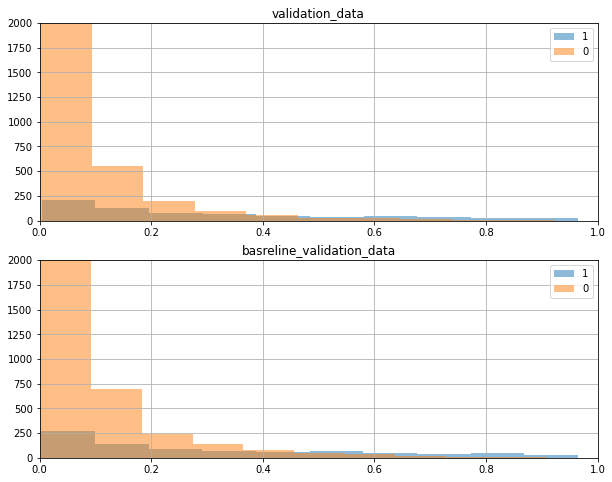

In [272]:
# 予測値の分布
y_va1_pred_prob = model.predict(x_va1)[:,1]
y_va2_pred_prob = model.predict(x_va2)[:,1]

fig = plt.figure(figsize=(10,8))


fig.add_subplot(2,1,1)
plt.title('validation_data')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.axis([0, 1, 0, 2000])

plt.grid()
plt.legend()

fig.add_subplot(2,1,2)
plt.title('basreline_validation_data')
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.axis([0, 1, 0, 2000])

plt.grid()
plt.legend()

## チューニング

In [26]:
import optuna

In [29]:
# 探索するパラメータ

params_base = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metrics': 'auc',
    'learning_rate': 0.02,
    'n_estimators': 100000,
    'bagging_freq': 1,
    'seed': 123,
}
random_state=123

def objective(trial):
    # 探索するパラメータ
    params_tuning = {
        'num_leaves': trial.suggest_int('num_leaves',8,256),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',5,200),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-5, 1e-2, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-2, 1e2, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 1e2, log=True),
    }
    params_tuning.update(params_base)
    
    # モデル学習・評価
    list_metrics = []
    cv = list(StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state).split(x_train, y_train))
    for nfold in np.arange(4):
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = x_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
        x_va, y_va = x_train.loc[idx_va, :], y_train.loc[idx_va, :]
        cat_cols = ['facility_id', 'icu_id']
        x_tr, x_va = target_encoding(cat_cols, x_tr, y_tr, x_va)
        train_weight = compute_sample_weight(class_weight='balanced', y=y_tr).astype('float32')
    
        model = lgb.LGBMClassifier(**params_tuning)
        model.fit(x_tr,
                  y_tr,
                  eval_set=[(x_tr, y_tr), (x_va, y_va)],
                  early_stopping_rounds=100,
                  verbose=0,
                  sample_weight = train_weight
                 )
        y_va_pred = model.predict_proba(x_va)[:,1]
        metric_va = accuracy_score(y_va, np.where(y_va_pred>0.5, 1, 0))
        list_metrics.append(metric_va)
        
    # 評価値の計算
    metrics = np.mean(list_metrics)
    
    return metrics

In [30]:
sampler = optuna.samplers.TPESampler(seed=random_state)
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(objective, n_trials=30)

[I 2023-03-27 08:10:52,385] A new study created in memory with name: no-name-6d507e69-96d2-4c1b-a0eb-d5eb0aa38957


[LightGBM] [Warning] feature_fraction is set=0.7756573845414456, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7756573845414456
[LightGBM] [Warning] bagging_fraction is set=0.8597344848927815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8597344848927815
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.792414358623587e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.792414358623587e-05
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7756573845414456, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7756573845414456
[LightGBM] [Warning] bagging_fraction is set=0.8597344848927815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.859734484

[I 2023-03-27 08:12:12,219] Trial 0 finished with value: 0.881111394495306 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 4.792414358623587e-05, 'feature_fraction': 0.7756573845414456, 'bagging_fraction': 0.8597344848927815, 'reg_alpha': 0.492522233779106, 'reg_lambda': 83.76388146302445}. Best is trial 0 with value: 0.881111394495306.


[LightGBM] [Warning] feature_fraction is set=0.6715890080754348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6715890080754348
[LightGBM] [Warning] bagging_fraction is set=0.8645248536920208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8645248536920208
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00015009027543233888, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00015009027543233888
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6715890080754348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6715890080754348
[LightGBM] [Warning] bagging_fraction is set=0.8645248536920208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8645248

[I 2023-03-27 08:12:56,070] Trial 1 finished with value: 0.9033858426149493 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 99, 'min_sum_hessian_in_leaf': 0.00015009027543233888, 'feature_fraction': 0.6715890080754348, 'bagging_fraction': 0.8645248536920208, 'reg_alpha': 0.567922374174008, 'reg_lambda': 0.01732652966363563}. Best is trial 1 with value: 0.9033858426149493.


[LightGBM] [Warning] feature_fraction is set=0.5877258780737462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5877258780737462
[LightGBM] [Warning] bagging_fraction is set=0.7657756869209191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7657756869209191
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.52756635172055e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.52756635172055e-05
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5877258780737462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5877258780737462
[LightGBM] [Warning] bagging_fraction is set=0.7657756869209191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.765775686

[I 2023-03-27 08:13:31,604] Trial 2 finished with value: 0.8843433513033084 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 149, 'min_sum_hessian_in_leaf': 3.52756635172055e-05, 'feature_fraction': 0.5877258780737462, 'bagging_fraction': 0.7657756869209191, 'reg_alpha': 1.3406343673102123, 'reg_lambda': 3.4482904089131434}. Best is trial 1 with value: 0.9033858426149493.


[LightGBM] [Warning] feature_fraction is set=0.8612216912851107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8612216912851107
[LightGBM] [Warning] bagging_fraction is set=0.6614794569265892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6614794569265892
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0006808799287054756, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0006808799287054756
[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8612216912851107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8612216912851107
[LightGBM] [Warning] bagging_fraction is set=0.6614794569265892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6614794

[I 2023-03-27 08:14:09,266] Trial 3 finished with value: 0.8842266213801941 and parameters: {'num_leaves': 219, 'min_data_in_leaf': 146, 'min_sum_hessian_in_leaf': 0.0006808799287054756, 'feature_fraction': 0.8612216912851107, 'bagging_fraction': 0.6614794569265892, 'reg_alpha': 0.2799978022399009, 'reg_lambda': 0.08185645330667264}. Best is trial 1 with value: 0.9033858426149493.


[LightGBM] [Warning] feature_fraction is set=0.7168505863397641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7168505863397641
[LightGBM] [Warning] bagging_fraction is set=0.7154313816648219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7154313816648219
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.889360449174926e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.889360449174926e-05
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7168505863397641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7168505863397641
[LightGBM] [Warning] bagging_fraction is set=0.7154313816648219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7154313

[I 2023-03-27 08:14:42,903] Trial 4 finished with value: 0.8770422102729732 and parameters: {'num_leaves': 81, 'min_data_in_leaf': 128, 'min_sum_hessian_in_leaf': 1.889360449174926e-05, 'feature_fraction': 0.7168505863397641, 'bagging_fraction': 0.7154313816648219, 'reg_alpha': 0.9434967110751797, 'reg_lambda': 0.5050346330980694}. Best is trial 1 with value: 0.9033858426149493.


[LightGBM] [Warning] feature_fraction is set=0.9720800091019398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9720800091019398
[LightGBM] [Warning] bagging_fraction is set=0.7509183379421682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7509183379421682
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.004788147156768277, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.004788147156768277
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9720800091019398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9720800091019398
[LightGBM] [Warning] bagging_fraction is set=0.7509183379421682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75091833794

[I 2023-03-27 08:15:31,907] Trial 5 finished with value: 0.8778987276282181 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 88, 'min_sum_hessian_in_leaf': 0.004788147156768277, 'feature_fraction': 0.9720800091019398, 'bagging_fraction': 0.7509183379421682, 'reg_alpha': 3.1319282717196035, 'reg_lambda': 0.029005047452739414}. Best is trial 1 with value: 0.9033858426149493.


[LightGBM] [Warning] feature_fraction is set=0.6252276826982534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6252276826982534
[LightGBM] [Warning] bagging_fraction is set=0.7415171321313522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415171321313522
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.003971252247766701, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.003971252247766701
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6252276826982534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6252276826982534
[LightGBM] [Warning] bagging_fraction is set=0.7415171321313522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.74151713213

[I 2023-03-27 08:16:24,251] Trial 6 finished with value: 0.8301758702735702 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 86, 'min_sum_hessian_in_leaf': 0.003971252247766701, 'feature_fraction': 0.6252276826982534, 'bagging_fraction': 0.7415171321313522, 'reg_alpha': 87.54657140659076, 'reg_lambda': 1.1965765212602313}. Best is trial 1 with value: 0.9033858426149493.


[LightGBM] [Warning] feature_fraction is set=0.8015300642054637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8015300642054637
[LightGBM] [Warning] bagging_fraction is set=0.7725340032332324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7725340032332324
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0030131614432849746, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0030131614432849746
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8015300642054637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8015300642054637
[LightGBM] [Warning] bagging_fraction is set=0.7725340032332324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.772534003

[I 2023-03-27 08:17:17,600] Trial 7 finished with value: 0.9035224235857501 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 0.0030131614432849746, 'feature_fraction': 0.8015300642054637, 'bagging_fraction': 0.7725340032332324, 'reg_alpha': 0.23499322154972468, 'reg_lambda': 0.1646202117975735}. Best is trial 7 with value: 0.9035224235857501.


[LightGBM] [Warning] feature_fraction is set=0.7552111687390055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7552111687390055
[LightGBM] [Warning] bagging_fraction is set=0.8346568914811361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8346568914811361
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00423029374725911, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00423029374725911
[LightGBM] [Warning] min_data_in_leaf is set=138, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=138
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7552111687390055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7552111687390055
[LightGBM] [Warning] bagging_fraction is set=0.8346568914811361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.83465689148

[I 2023-03-27 08:17:53,432] Trial 8 finished with value: 0.8767498084351151 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 138, 'min_sum_hessian_in_leaf': 0.00423029374725911, 'feature_fraction': 0.7552111687390055, 'bagging_fraction': 0.8346568914811361, 'reg_alpha': 2.206714812711709, 'reg_lambda': 3.1594683442464033}. Best is trial 7 with value: 0.9035224235857501.


[LightGBM] [Warning] feature_fraction is set=0.8818414207216692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8818414207216692
[LightGBM] [Warning] bagging_fraction is set=0.6218331872684371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6218331872684371
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.7765808030254076e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.7765808030254076e-05
[LightGBM] [Warning] min_data_in_leaf is set=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8818414207216692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8818414207216692
[LightGBM] [Warning] bagging_fraction is set=0.6218331872684371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.62183

[I 2023-03-27 08:18:30,038] Trial 9 finished with value: 0.8768086033257799 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 170, 'min_sum_hessian_in_leaf': 1.7765808030254076e-05, 'feature_fraction': 0.8818414207216692, 'bagging_fraction': 0.6218331872684371, 'reg_alpha': 0.05982625838323253, 'reg_lambda': 1.9490717640641542}. Best is trial 7 with value: 0.9035224235857501.


[LightGBM] [Warning] feature_fraction is set=0.5040305717020102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5040305717020102
[LightGBM] [Warning] bagging_fraction is set=0.9940542446575642, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9940542446575642
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0010167214653943027, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0010167214653943027
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5040305717020102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5040305717020102
[LightGBM] [Warning] bagging_fraction is set=0.9940542446575642, subsample=1.0 will be ignored. Current value: bagging_fraction=0.99405424465

[I 2023-03-27 08:18:56,459] Trial 10 finished with value: 0.8473101602909165 and parameters: {'num_leaves': 32, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 0.0010167214653943027, 'feature_fraction': 0.5040305717020102, 'bagging_fraction': 0.9940542446575642, 'reg_alpha': 0.010612397212799423, 'reg_lambda': 0.1661409929489422}. Best is trial 7 with value: 0.9035224235857501.


[LightGBM] [Warning] feature_fraction is set=0.6893072883706839, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6893072883706839
[LightGBM] [Warning] bagging_fraction is set=0.5643816257078462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5643816257078462
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0002546304993969339, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0002546304993969339
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6893072883706839, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6893072883706839
[LightGBM] [Warning] bagging_fraction is set=0.5643816257078462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.564381625

[I 2023-03-27 08:22:12,364] Trial 11 finished with value: 0.9028212812451548 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.0002546304993969339, 'feature_fraction': 0.6893072883706839, 'bagging_fraction': 0.5643816257078462, 'reg_alpha': 0.10108607276304732, 'reg_lambda': 0.010211649165953098}. Best is trial 7 with value: 0.9035224235857501.


[LightGBM] [Warning] feature_fraction is set=0.8175314403750262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8175314403750262
[LightGBM] [Warning] bagging_fraction is set=0.8626569725135499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8626569725135499
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.000153402164637483, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.000153402164637483
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8175314403750262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8175314403750262
[LightGBM] [Warning] bagging_fraction is set=0.8626569725135499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.86265697251

[I 2023-03-27 08:25:11,608] Trial 12 finished with value: 0.8963765711292914 and parameters: {'num_leaves': 255, 'min_data_in_leaf': 41, 'min_sum_hessian_in_leaf': 0.000153402164637483, 'feature_fraction': 0.8175314403750262, 'bagging_fraction': 0.8626569725135499, 'reg_alpha': 8.37591328058755, 'reg_lambda': 0.01045117234553353}. Best is trial 7 with value: 0.9035224235857501.


[LightGBM] [Warning] feature_fraction is set=0.6800062881915976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6800062881915976
[LightGBM] [Warning] bagging_fraction is set=0.5111428766066355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5111428766066355
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.008932219618102614, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.008932219618102614
[LightGBM] [Warning] min_data_in_leaf is set=190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=190
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6800062881915976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6800062881915976
[LightGBM] [Warning] bagging_fraction is set=0.5111428766066355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.511142876

[I 2023-03-27 08:27:38,684] Trial 13 finished with value: 0.8689615751656204 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 190, 'min_sum_hessian_in_leaf': 0.008932219618102614, 'feature_fraction': 0.6800062881915976, 'bagging_fraction': 0.5111428766066355, 'reg_alpha': 0.17052736553266273, 'reg_lambda': 0.0988056140193565}. Best is trial 7 with value: 0.9035224235857501.


[LightGBM] [Warning] feature_fraction is set=0.8041563305513639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8041563305513639
[LightGBM] [Warning] bagging_fraction is set=0.9449350856793115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9449350856793115
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00011414918234944389, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00011414918234944389
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8041563305513639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8041563305513639
[LightGBM] [Warning] bagging_fraction is set=0.9449350856793115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9449350

[I 2023-03-27 08:30:09,640] Trial 14 finished with value: 0.9137250356014663 and parameters: {'num_leaves': 215, 'min_data_in_leaf': 70, 'min_sum_hessian_in_leaf': 0.00011414918234944389, 'feature_fraction': 0.8041563305513639, 'bagging_fraction': 0.9449350856793115, 'reg_alpha': 0.045693362410957825, 'reg_lambda': 0.038934140387364174}. Best is trial 14 with value: 0.9137250356014663.


[LightGBM] [Warning] feature_fraction is set=0.798973943231285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.798973943231285
[LightGBM] [Warning] bagging_fraction is set=0.9883163331495053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9883163331495053
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001215432268892957, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001215432268892957
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.798973943231285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.798973943231285
[LightGBM] [Warning] bagging_fraction is set=0.9883163331495053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.988316333149505

[I 2023-03-27 08:31:17,831] Trial 15 finished with value: 0.9143091750480853 and parameters: {'num_leaves': 219, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001215432268892957, 'feature_fraction': 0.798973943231285, 'bagging_fraction': 0.9883163331495053, 'reg_alpha': 0.03988616968038969, 'reg_lambda': 0.04384568349950474}. Best is trial 15 with value: 0.9143091750480853.


[LightGBM] [Warning] feature_fraction is set=0.8974152759983636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8974152759983636
[LightGBM] [Warning] bagging_fraction is set=0.9915442564871022, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9915442564871022
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0007547212191327465, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0007547212191327465
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8974152759983636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8974152759983636
[LightGBM] [Warning] bagging_fraction is set=0.9915442564871022, subsample=1.0 will be ignored. Current value: bagging_fraction=0.991544256

[I 2023-03-27 08:32:24,169] Trial 16 finished with value: 0.9105513853695867 and parameters: {'num_leaves': 225, 'min_data_in_leaf': 65, 'min_sum_hessian_in_leaf': 0.0007547212191327465, 'feature_fraction': 0.8974152759983636, 'bagging_fraction': 0.9915442564871022, 'reg_alpha': 0.020436805378618597, 'reg_lambda': 0.03433559455816001}. Best is trial 15 with value: 0.9143091750480853.


[LightGBM] [Warning] feature_fraction is set=0.8330744197268897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8330744197268897
[LightGBM] [Warning] bagging_fraction is set=0.9308943929336889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9308943929336889
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8.935790929091197e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.935790929091197e-05
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8330744197268897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8330744197268897
[LightGBM] [Warning] bagging_fraction is set=0.9308943929336889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.930894392

[I 2023-03-27 08:33:27,286] Trial 17 finished with value: 0.9135693330217827 and parameters: {'num_leaves': 215, 'min_data_in_leaf': 51, 'min_sum_hessian_in_leaf': 8.935790929091197e-05, 'feature_fraction': 0.8330744197268897, 'bagging_fraction': 0.9308943929336889, 'reg_alpha': 0.04250632026048154, 'reg_lambda': 0.042677457059612324}. Best is trial 15 with value: 0.9143091750480853.


[LightGBM] [Warning] feature_fraction is set=0.7474499041095187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7474499041095187
[LightGBM] [Warning] bagging_fraction is set=0.9422115556402889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9422115556402889
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0004380338011497303, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0004380338011497303
[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7474499041095187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7474499041095187
[LightGBM] [Warning] bagging_fraction is set=0.9422115556402889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9422115

[I 2023-03-27 08:34:23,871] Trial 18 finished with value: 0.9061118388312092 and parameters: {'num_leaves': 253, 'min_data_in_leaf': 113, 'min_sum_hessian_in_leaf': 0.0004380338011497303, 'feature_fraction': 0.7474499041095187, 'bagging_fraction': 0.9422115556402889, 'reg_alpha': 0.029505797157008604, 'reg_lambda': 0.3613816693235936}. Best is trial 15 with value: 0.9143091750480853.


[LightGBM] [Warning] feature_fraction is set=0.9170263295138465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9170263295138465
[LightGBM] [Warning] bagging_fraction is set=0.9252732251354118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9252732251354118
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0014854275432688256, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0014854275432688256
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9170263295138465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9170263295138465
[LightGBM] [Warning] bagging_fraction is set=0.9252732251354118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.925273225

[I 2023-03-27 08:35:26,251] Trial 19 finished with value: 0.9095580989969473 and parameters: {'num_leaves': 207, 'min_data_in_leaf': 73, 'min_sum_hessian_in_leaf': 0.0014854275432688256, 'feature_fraction': 0.9170263295138465, 'bagging_fraction': 0.9252732251354118, 'reg_alpha': 0.010027969419668254, 'reg_lambda': 0.044612610488335765}. Best is trial 15 with value: 0.9143091750480853.


[LightGBM] [Warning] feature_fraction is set=0.8309878210063437, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8309878210063437
[LightGBM] [Warning] bagging_fraction is set=0.9921935443390247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9921935443390247
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0003715334734853126, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0003715334734853126
[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8309878210063437, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8309878210063437
[LightGBM] [Warning] bagging_fraction is set=0.9921935443390247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9921935

[I 2023-03-27 08:36:06,717] Trial 20 finished with value: 0.8284818206865326 and parameters: {'num_leaves': 8, 'min_data_in_leaf': 113, 'min_sum_hessian_in_leaf': 0.0003715334734853126, 'feature_fraction': 0.8309878210063437, 'bagging_fraction': 0.9921935443390247, 'reg_alpha': 0.07760481503455585, 'reg_lambda': 0.023199708121192097}. Best is trial 15 with value: 0.9143091750480853.


[LightGBM] [Warning] feature_fraction is set=0.8091273410784455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8091273410784455
[LightGBM] [Warning] bagging_fraction is set=0.9273977096274312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9273977096274312
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6.893857790440731e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6.893857790440731e-05
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8091273410784455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8091273410784455
[LightGBM] [Warning] bagging_fraction is set=0.9273977096274312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.927397709

[I 2023-03-27 08:37:14,049] Trial 21 finished with value: 0.915029580032509 and parameters: {'num_leaves': 205, 'min_data_in_leaf': 45, 'min_sum_hessian_in_leaf': 6.893857790440731e-05, 'feature_fraction': 0.8091273410784455, 'bagging_fraction': 0.9273977096274312, 'reg_alpha': 0.04667317333314764, 'reg_lambda': 0.050582355537352366}. Best is trial 21 with value: 0.915029580032509.


[LightGBM] [Warning] feature_fraction is set=0.7995472472441396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7995472472441396
[LightGBM] [Warning] bagging_fraction is set=0.9104388655687001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9104388655687001
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7.391470668175935e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7.391470668175935e-05
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7995472472441396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7995472472441396
[LightGBM] [Warning] bagging_fraction is set=0.9104388655687001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.910438865

[I 2023-03-27 08:38:41,768] Trial 22 finished with value: 0.9142896485324238 and parameters: {'num_leaves': 234, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 7.391470668175935e-05, 'feature_fraction': 0.7995472472441396, 'bagging_fraction': 0.9104388655687001, 'reg_alpha': 0.026721044041056047, 'reg_lambda': 0.07451032272050791}. Best is trial 21 with value: 0.915029580032509.


[LightGBM] [Warning] feature_fraction is set=0.7731462798990519, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7731462798990519
[LightGBM] [Warning] bagging_fraction is set=0.9006517574979365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9006517574979365
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.0257826229045205e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.0257826229045205e-05
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7731462798990519, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7731462798990519
[LightGBM] [Warning] bagging_fraction is set=0.9006517574979365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9006517

[I 2023-03-27 08:39:42,581] Trial 23 finished with value: 0.9076305880471762 and parameters: {'num_leaves': 240, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 1.0257826229045205e-05, 'feature_fraction': 0.7731462798990519, 'bagging_fraction': 0.9006517574979365, 'reg_alpha': 0.02312152610279702, 'reg_lambda': 0.07467868849739885}. Best is trial 21 with value: 0.915029580032509.


[LightGBM] [Warning] feature_fraction is set=0.8554704582704863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8554704582704863
[LightGBM] [Warning] bagging_fraction is set=0.8157420611929699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8157420611929699
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6.294576802299786e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6.294576802299786e-05
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8554704582704863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8554704582704863
[LightGBM] [Warning] bagging_fraction is set=0.8157420611929699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.815742061

[I 2023-03-27 08:40:44,720] Trial 24 finished with value: 0.9112910438988101 and parameters: {'num_leaves': 198, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 6.294576802299786e-05, 'feature_fraction': 0.8554704582704863, 'bagging_fraction': 0.8157420611929699, 'reg_alpha': 0.1000586051654101, 'reg_lambda': 0.19997413091609148}. Best is trial 21 with value: 0.915029580032509.


[LightGBM] [Warning] feature_fraction is set=0.7373471207171156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7373471207171156
[LightGBM] [Warning] bagging_fraction is set=0.8967208581588109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8967208581588109
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00027797661617380033, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00027797661617380033
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7373471207171156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7373471207171156
[LightGBM] [Warning] bagging_fraction is set=0.8967208581588109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8967208

[I 2023-03-27 08:41:28,745] Trial 25 finished with value: 0.8993166690081501 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 50, 'min_sum_hessian_in_leaf': 0.00027797661617380033, 'feature_fraction': 0.7373471207171156, 'bagging_fraction': 0.8967208581588109, 'reg_alpha': 0.017634090175269762, 'reg_lambda': 0.055486302297669474}. Best is trial 21 with value: 0.915029580032509.


[LightGBM] [Warning] feature_fraction is set=0.9359202818582051, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9359202818582051
[LightGBM] [Warning] bagging_fraction is set=0.9637477392254032, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9637477392254032
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6.356298381849394e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6.356298381849394e-05
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9359202818582051, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9359202818582051
[LightGBM] [Warning] bagging_fraction is set=0.9637477392254032, subsample=1.0 will be ignored. Current value: bagging_fraction=0.963747739

[I 2023-03-27 08:42:40,161] Trial 26 finished with value: 0.9139977198440596 and parameters: {'num_leaves': 234, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 6.356298381849394e-05, 'feature_fraction': 0.9359202818582051, 'bagging_fraction': 0.9637477392254032, 'reg_alpha': 0.03150389776898005, 'reg_lambda': 0.09144538998867943}. Best is trial 21 with value: 0.915029580032509.


[LightGBM] [Warning] feature_fraction is set=0.7880733307854664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7880733307854664
[LightGBM] [Warning] bagging_fraction is set=0.8995181385779787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8995181385779787
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00015169247729063443, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00015169247729063443
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7880733307854664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7880733307854664
[LightGBM] [Warning] bagging_fraction is set=0.8995181385779787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8995181

[I 2023-03-27 08:43:39,462] Trial 27 finished with value: 0.9119336885836791 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 49, 'min_sum_hessian_in_leaf': 0.00015169247729063443, 'feature_fraction': 0.7880733307854664, 'bagging_fraction': 0.8995181385779787, 'reg_alpha': 0.12484292645725906, 'reg_lambda': 0.016607645835344912}. Best is trial 21 with value: 0.915029580032509.


[LightGBM] [Warning] feature_fraction is set=0.8586951177330127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8586951177330127
[LightGBM] [Warning] bagging_fraction is set=0.9538875680745383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9538875680745383
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00021981389524911843, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00021981389524911843
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8586951177330127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8586951177330127
[LightGBM] [Warning] bagging_fraction is set=0.9538875680745383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9538875

[I 2023-03-27 08:45:17,879] Trial 28 finished with value: 0.9118166705246548 and parameters: {'num_leaves': 235, 'min_data_in_leaf': 85, 'min_sum_hessian_in_leaf': 0.00021981389524911843, 'feature_fraction': 0.8586951177330127, 'bagging_fraction': 0.9538875680745383, 'reg_alpha': 0.05392514580590439, 'reg_lambda': 0.020621949248373524}. Best is trial 21 with value: 0.915029580032509.


[LightGBM] [Warning] feature_fraction is set=0.7777756551083584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7777756551083584
[LightGBM] [Warning] bagging_fraction is set=0.8182312770946693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8182312770946693
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.073757643365435e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.073757643365435e-05
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7777756551083584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7777756551083584
[LightGBM] [Warning] bagging_fraction is set=0.8182312770946693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.818231277

[I 2023-03-27 08:46:16,098] Trial 29 finished with value: 0.913102046335166 and parameters: {'num_leaves': 198, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 4.073757643365435e-05, 'feature_fraction': 0.7777756551083584, 'bagging_fraction': 0.8182312770946693, 'reg_alpha': 0.33236916530073274, 'reg_lambda': 0.34068251293058605}. Best is trial 21 with value: 0.915029580032509.


In [31]:
trial = study.best_trial
print('acc(best)={:.4f}'.format(trial.value))
display(trial.params)

acc(best)=0.9150


{'num_leaves': 205,
 'min_data_in_leaf': 45,
 'min_sum_hessian_in_leaf': 6.893857790440731e-05,
 'feature_fraction': 0.8091273410784455,
 'bagging_fraction': 0.9273977096274312,
 'reg_alpha': 0.04667317333314764,
 'reg_lambda': 0.050582355537352366}

In [32]:
params_best = trial.params
params_best.update(params_base)
display(params_best)

{'num_leaves': 205,
 'min_data_in_leaf': 45,
 'min_sum_hessian_in_leaf': 6.893857790440731e-05,
 'feature_fraction': 0.8091273410784455,
 'bagging_fraction': 0.9273977096274312,
 'reg_alpha': 0.04667317333314764,
 'reg_lambda': 0.050582355537352366,
 'boosting_type': 'gbdt',
 'objective': 'binary',
 'metrics': 'auc',
 'learning_rate': 0.02,
 'n_estimators': 100000,
 'bagging_freq': 1,
 'seed': 123}